In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

In [3]:
train = datasets.MNIST(root = '.', train = True, download=True, transform = transforms.ToTensor())
test = datasets.MNIST(root = '.', train = False, download=True, transform = transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=256, shuffle=True)

In [5]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(in_features=784, out_features=32)
        self.activation0 = nn.ReLU()
        self.dense1 = nn.Linear(32, 784)
        self.activation1 = nn.Sigmoid()

    def forward(self, X):
        # Numero inderteminado de registro
        X = X.view(-1, 28*28) # Transdorma a matriz 28*28 em um vetor
        X = self.dense0(X)
        X = self.activation0(X)
        X = self.dense1(X)
        X = self.activation1(X)

        return X

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [8]:
model = autoencoder()
model.to(device)

autoencoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
  (dense1): Linear(in_features=32, out_features=784, bias=True)
  (activation1): Sigmoid()
)

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [10]:
for epoch in range(20):
    running_loss_train = 0.
    for data in train_loader:
        model.train()
        inputs, _ = data 
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)

        loss = criterion(outputs, inputs.view(*outputs.shape)) # transforma os inputs em vetor

        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()

    running_loss_val = 0.
    for data in train_loader:
        model.eval()

        inputs, _ = data
        inputs = inputs.to(device)

        outputs = model.forward(inputs)

        loss = criterion(outputs, inputs.view(*outputs.shape)) # transforma os inputs em vetor

        running_loss_val += loss.item()
    print('ÉPOCA {:3d}: perda_train {:.5f} perda_val {:.5f}'.format(epoch + 1, running_loss_train/len(train_loader), running_loss_val/len(test_loader)))

ÉPOCA   1: perda_train 0.29529 perda_val 1.16992
ÉPOCA   2: perda_train 0.18119 perda_val 0.98222
ÉPOCA   3: perda_train 0.15759 perda_val 0.87673
ÉPOCA   4: perda_train 0.14333 perda_val 0.81137
ÉPOCA   5: perda_train 0.13427 perda_val 0.76727
ÉPOCA   6: perda_train 0.12780 perda_val 0.73547
ÉPOCA   7: perda_train 0.12312 perda_val 0.70835
ÉPOCA   8: perda_train 0.11805 perda_val 0.68231
ÉPOCA   9: perda_train 0.11506 perda_val 0.66903
ÉPOCA  10: perda_train 0.11310 perda_val 0.65957
ÉPOCA  11: perda_train 0.11184 perda_val 0.65377
ÉPOCA  12: perda_train 0.11099 perda_val 0.64956
ÉPOCA  13: perda_train 0.11038 perda_val 0.64730
ÉPOCA  14: perda_train 0.11003 perda_val 0.64480
ÉPOCA  15: perda_train 0.10971 perda_val 0.64060
ÉPOCA  16: perda_train 0.10814 perda_val 0.63228
ÉPOCA  17: perda_train 0.10751 perda_val 0.62971
ÉPOCA  18: perda_train 0.10714 perda_val 0.62776
ÉPOCA  19: perda_train 0.10689 perda_val 0.62707
ÉPOCA  20: perda_train 0.10675 perda_val 0.62644


In [11]:
list(model.children())

[Linear(in_features=784, out_features=32, bias=True),
 ReLU(),
 Linear(in_features=32, out_features=784, bias=True),
 Sigmoid()]

In [12]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = list(model.children())[0] # Primeira camada
        self.activation0 = list(model.children())[1] # Relu
        
    def forward(self, X):
        X = X.view(-1, 28*28)
        X = self.dense0(X)
        X = self.activation0(X)
        return X

In [13]:
model1 = encoder()
model1.to(device)

encoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
)

In [14]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = list(model.children())[2]
        self.activation0 = list(model.children())[3]
    
    def forward(self, X):
        X = self.dense0(X)
        X = self.activation0(X)
        return X

In [15]:
model2 = decoder()
model2  .to(device)

decoder(
  (dense0): Linear(in_features=32, out_features=784, bias=True)
  (activation0): Sigmoid()
)

In [17]:
numero_imagens = 10
imagens_teste = next(iter(test_loader))[0][:numero_imagens]
imagens_teste = imagens_teste.to(device)

In [19]:
# Imagens codificadas
model1.eval()
imagens_codificadas = model1(imagens_teste)

In [20]:
imagens_codificadas.shape

torch.Size([10, 32])

In [21]:
model2.eval()
imagens_decodificadas = model2(imagens_codificadas)

In [22]:
imagens_decodificadas.shape

torch.Size([10, 784])

In [24]:
imagens_teste = imagens_teste.detach().cpu().numpy().reshape(-1, 28, 28)
imagens_codificadas = imagens_codificadas.detach().cpu().numpy().reshape(-1, 8, 4)
imagens_decodificadas = imagens_decodificadas.detach().cpu().numpy().reshape(-1, 28, 28)

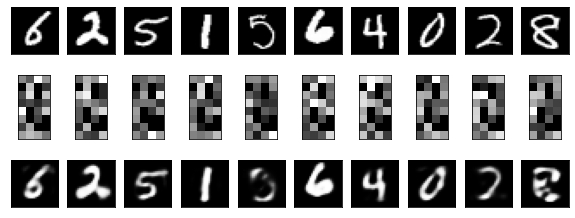

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=numero_imagens, figsize=(10, 4))
print(axes)
for imagens, ax_row in zip([imagens_teste, imagens_codificadas, imagens_decodificadas], axes):
  for img, ax in zip(imagens, ax_row):
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)